# GDP Growth Cleaning (WDI)

This section prepares GDP Growth data from the
World Development Indicators (WDI).

Steps:
- Filter valid ISO countries
- Convert wide data to panel format
- Validate country-year coverage
- Inspect distribution

In [1]:
# =========================
# SETUP
# =========================

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_PATH = "/content/drive/MyDrive/thesis_project/"

RAW_DATA = BASE_PATH + "data/raw/"
INTERIM_DATA = BASE_PATH + "data/interim/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load ISO Country Codes

In [4]:
iso_url = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
iso = pd.read_csv(iso_url)

valid_codes = iso["ISO3166-1-Alpha-3"].dropna().unique()

print("ISO codes loaded:", len(valid_codes))

ISO codes loaded: 249


## WDI Cleaning Function
Reusable function converting WDI files into panel format.

In [5]:
def clean_wdi(file_path, iso_codes, value_name):

    df = pd.read_excel(file_path, skiprows=3)

    df = df[df["Country Code"].isin(iso_codes)]

    year_cols = [c for c in df.columns if str(c).isdigit()]

    df_panel = df.melt(
        id_vars=["Country Name", "Country Code"],
        value_vars=year_cols,
        var_name="Year",
        value_name=value_name
    )

    df_panel["Year"] = df_panel["Year"].astype(int)
    df_panel[value_name] = pd.to_numeric(
        df_panel[value_name], errors="coerce"
    )

    df_panel = df_panel.dropna(subset=[value_name])

    return df_panel

## Clean GDP Growth Dataset

In [6]:
gdp_growth = clean_wdi(
    RAW_DATA + "WDI_GDP_Growth_raw.xls",
    valid_codes,
    "GDP_growth"
)

gdp_growth = gdp_growth.sort_values(
    ["Country Code", "Year"]
).reset_index(drop=True)

## Dataset Validation
Check panel dimensions.

In [7]:
print("Countries:", gdp_growth["Country Code"].nunique())
print("Years:", gdp_growth["Year"].nunique())

Countries: 212
Years: 64


## Distribution Inspection

In [8]:
gdp_growth["GDP_growth"].describe()

,GDP_growth
count,11184.000000
mean,3.629010
std,6.796682
min,-64.047107
25%,1.174327
50%,3.762196
75%,6.254809
max,149.972963


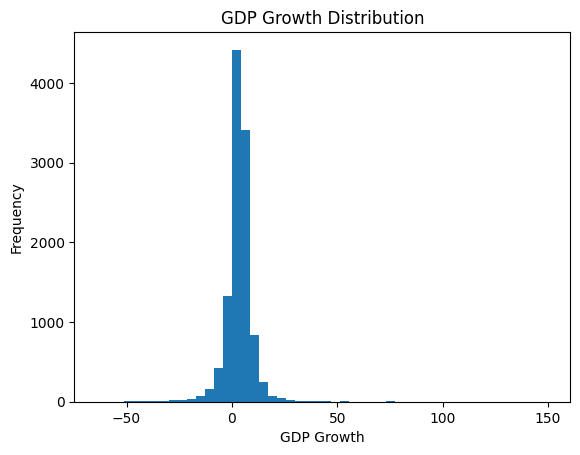

In [9]:
plt.hist(gdp_growth["GDP_growth"], bins=50)
plt.title("GDP Growth Distribution")
plt.xlabel("GDP Growth")
plt.ylabel("Frequency")
plt.show()

## Extreme Values Inspection

In [10]:
gdp_growth.sort_values("GDP_growth").head()

,Country Name,Country Code,Year,GDP_growth
4866,Iraq,IRQ,1991,-64.047107
6251,"Macao SAR, China",MAC,2020,-54.402093
5770,Liberia,LBR,1990,-51.030865
5855,Libya,LBY,2011,-50.338515
8739,Rwanda,RWA,1994,-50.248067


In [11]:
gdp_growth.sort_values("GDP_growth").tail()

,Country Name,Country Code,Year,GDP_growth
7838,Oman,OMN,1968,81.887797
5633,Kuwait,KWT,1992,82.809329
5856,Libya,LBY,2012,86.826748
5777,Liberia,LBR,1997,106.279814
3913,Equatorial Guinea,GNQ,1997,149.972963


## Save Clean Dataset

In [12]:
gdp_growth.to_csv(
    INTERIM_DATA + "wdi_gdp_growth_clean.csv",
    index=False,
    float_format="%.10f"
)

## Pipeline Completion

In [13]:
print("✅ GDP Growth cleaning completed.")

✅ GDP Growth cleaning completed.
